# 3-c: Uncertainty Applications

This last lab session will focus on applications based on uncertainty estimation. We will first use MC Dropout variational inference to qualitatively evaluate the most uncertain images according to the mode. Then, we'll move to 2 examples where good uncertainty estimation is crucial : failure prediction and out-of-distribution detection.

**Goal**: Take hand on applying uncertainty estimation for failure prediction and out-of-distribution detection

### All Imports and Useful Functions

In [3]:
# @title Import libs

import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from matplotlib.pyplot import imread
from sklearn.metrics import average_precision_score, precision_recall_curve
from tqdm.notebook import tqdm

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {}
# kwargs = {'num_workers': 10, 'pin_memory': True} if use_cuda else {}

In [4]:
# @title Useful plot function


def plot_predicted_images(
    selected_idx, images, pred, labels, uncertainties, hists, mc_samples
):
    """Plot predicted images along with mean-pred probabilities histogram, maxprob frequencies and some class histograms
    across sampliong

    Args:
      selected_ix: (array) chosen index in the uncertainties tensor
      images: (tensor) images from the test set
      pred: (tensor) class predictions by the model
      labels: (tensor) true labels of the given dataset
      uncertainties: (tensor) uncertainty estimates of the given dataset
      errors: (tensor) 0/1 vector whether the model wrongly predicted a sample
      hists : (array) number of occurences by class in each sample fo the given dataset, only with MCDropout
      mc_samples: (tensor) prediction matrix for s=100 samples, only with MCDropout

    Returns:
        None
    """
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(selected_idx):
        # Plot original image
        plt.subplot(5, 6, 1 + 6 * i)
        plt.axis("off")
        plt.title(
            f"var-ratio={uncertainties[idx]:.3f}, \n gt={labels[idx]}, pred={pred[idx]}"
        )
        plt.imshow(images[idx], cmap="gray")

        # Plot mean probabilities
        plt.subplot(5, 6, 1 + 6 * i + 1)
        plt.title("Mean probs")
        plt.bar(range(10), mc_samples[idx].mean(0))
        plt.xticks(range(10))

        # Plot frequencies
        plt.subplot(5, 6, 1 + 6 * i + 2)
        plt.title("Maxprob frequencies")
        plt.bar(range(10), hists[idx])
        plt.xticks(range(10))

        # Plot probs frequency for specific class
        list_plotprobs = [
            hists[idx].argsort()[-1],
            hists[idx].argsort()[-2],
            hists[idx].argsort()[-4],
        ]
        ymax = max(
            [max(np.histogram(mc_samples[idx][:, c])[0]) for c in list_plotprobs]
        )
        for j, c in enumerate(list_plotprobs):
            plt.subplot(5, 6, 1 + 6 * i + (3 + j))
            plt.title(f"Samples probs of class {c}")
            plt.hist(mc_samples[idx][:, c], bins=np.arange(0, 1.1, 0.1))
            plt.ylim(0, np.ceil(ymax / 10) * 10)
            plt.xticks(np.arange(0, 1, 0.1), rotation=60)

    plt.tight_layout()
    plt.show()

## Part I: Monte-Carlo Dropout on MNIST

By appling MC Dropout variational inference method, we're interested to obtain an uncertainty measure which can be use to spot the most uncertain images in our dataset.

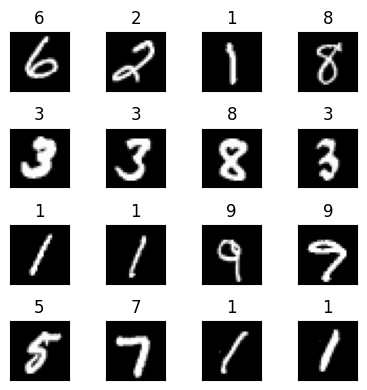

In [5]:
# Load MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
train_dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=128, **kwargs)

# Visualize some images
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(nrows=4, ncols=4)
for i, (image, label) in enumerate(zip(images, labels)):
    if i >= 16:
        break
    axes[i // 4][i % 4].imshow(images[i][0], cmap="gray")
    axes[i // 4][i % 4].set_title(f"{label}")
    axes[i // 4][i % 4].set_xticks([])
    axes[i // 4][i % 4].set_yticks([])
fig.set_size_inches(4, 4)
fig.tight_layout()

### I.1 LeNet-5 network with dropout layers

We will use a model in the style of LeNet-5 to implement Monte-Carlo dropout variational inference.

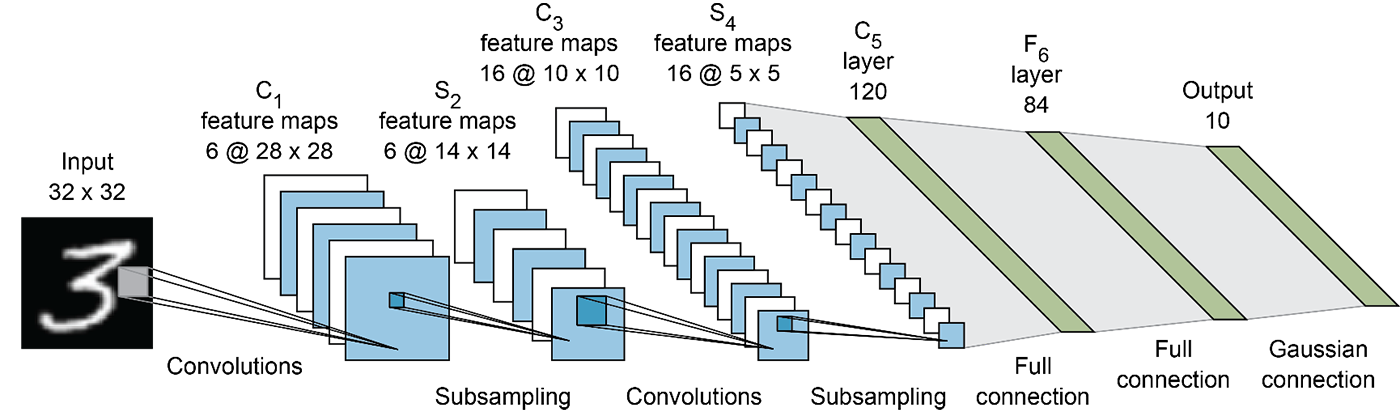

Compared to the previous figure, the model we will implement will be defined as :
- a convolutional layer with 6 channels, kernel size 5, padding 2 and ReLU activation
- a max pooling layer with kernel size 2
- a convolutional layer with 16 channels, kernel size 5  and ReLU activation
- a max pooling layer with kernel size 2

Then flatten and:
- a dropout layer with $p=0.25$
- a fully-connected layer of size 120 and ReLU activation
- a dropout layer with $p=0.5$
- a final fully-connected layer of size 10

In [6]:
# Implement a LeNet5-style neural network
# @title **[CODING TASK]** Implement a LeNet5-style neural network


class LeNet5(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        # ============ YOUR CODE HERE ============*
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        self.maxpool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, n_classes)

    def forward(self, x):
        # ============ YOUR CODE HERE ============
        # Be careful, the dropout layer should be also
        # activated during test time.
        # (Hint: we may want to look out at F.dropout())
        # x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # x = x.view(x.size(0), -1)  # flatten tensor
        # x = F.dropout(F.relu(self.fc1(x)), p=0.25, training=True)
        # x = F.dropout(F.relu(self.fc2(x)), p=0.5, training=True)
        # x = self.fc3(x)

        out = F.relu(self.conv1(x))
        out = self.maxpool1(out)
        out = F.relu(self.conv2(out))
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.25, training=True)
        out = F.relu(self.fc1(out))
        out = F.dropout(out, p=0.5, training=True)
        pred = self.fc2(out)
        return pred

Now let's train our model for 20 epochs using cross-entropy loss as usual.

In [7]:
# lenet = LeNet5(n_classes=len(train_dataset.classes)).to(device)
# lenet.train()
# optimizer = torch.optim.SGD(lenet.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# criterion = nn.CrossEntropyLoss()

# for i in range(20):
#     total_loss, correct = 0.0, 0.0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         output = lenet(images)
#         loss = criterion(output, labels)
#         total_loss += loss
#         correct += (output.argmax(-1) == labels).sum()
#         loss.backward()
#         optimizer.step()
#     print(f"[Epoch {i + 1:2d}] loss: {total_loss/ len(train_dataset):.2E} accuracy_train: {correct / len(train_dataset):.2%}")
# torch.save(lenet.state_dict(), 'lenet_final.cpkt')

In [8]:
# If you already train your model, you can load it instead using :
lenet = LeNet5(n_classes=len(train_dataset.classes)).to(device)
lenet.load_state_dict(torch.load("lenet_final.cpkt"))

<All keys matched successfully>

### I.2 Investigating most uncertain samples

For classification, there exists a few measures to compute uncertainty estimates:
- **var-ratios**: collect the predicted label for each stochastic forward pass. Find the most sampled label and compute:
$$ \text{variation-ratio}[x] = 1 - \frac{f_x}{T} $$
where $f_x$ is the frequency of the chosen label and $T$ the number of pass.

- **entropy**: captures the average amount of information contained in the predictive distribution.
$$ \mathcal{H}[y \vert x, \mathcal{D}] = - \sum_c \Big ( \frac{1}{T} \sum_t p(y=c \vert x, w_t) \Big ) \log \Big ( \frac{1}{T} \sum_t p(y=c \vert x, w_t) \Big )$$

- **mutual information** : points that maximise the mutual informations are points on which the model is uncertain on average
$$ \mathcal{I}[y,w \vert x, \mathcal{D}] = \mathcal{H}[y \vert x, \mathcal{D}]- \frac{1}{T} \sum_{c,t} p(y=c \vert x, w_t) \log p(y=c \vert x, w_t) $$

In [53]:
# @title **[CODING TASK]** Implement variational-ratio, entropy and mutual information


def predict_test_set(
    model, test_loader, mode="mcp", s=100, temp=5, epsilon=0.0006, verbose=True
):
    """Predict on a test set given a model
    # and a chosen method to compute uncertainty estimate
    # (mcp, MC-dropout with var-ratios/entropy/mutual information
    # ConfidNet and ODIN)

    Args:
      model: (nn.Module) a trained model
      test_loader: (torch.DataLoader) a Pytorch dataloader based on a dataset
      mode: (str) chosen uncertainty estimate method (mcp, var-ratios, entropy, mi, odin)
      s: (int) number of samples in MCDropout
      temp: (int, optional) value of T for temperature scaling in ODIN
      epsilon: (float, optional) value of epsilon for inverse adversarial perturbation in ODIN
      verbose: (bool, optional) printing progress bar when predicting

    Returns:
      pred: (tensor) class predictions by the model
      labels: (tensor) true labels of the given dataset
      uncertainties: (tensor) uncertainty estimates of the given dataset
      errors: (tensor) 0/1 vector whether the model wrongly predicted a sample
      hists : (array) number of occurences by class in each sample fo the given dataset, only with MCDropout
      mc_samples: (tensor) prediction matrix for s=100 samples, only with MCDropout
    """

    model.eval()
    preds, uncertainties, labels, errors = [], [], [], []
    mc_samples, hists = [], []

    loop = tqdm(test_loader, disable=not verbose)
    for images, targets in loop:
        images, targets = images.to(device), targets.to(device)

        if mode in ["mcp", "odin"]:
            model.training = False
            if mode == "odin":
                # Coding task in Section 3: implement ODIN
                images = odin_preprocessing(model, images, epsilon).to(device)
            with torch.no_grad():
                output = model(images)
            if isinstance(output, tuple):
                output = output[0]
            if mode == "odin":
                output = output / temp
            confidence, pred = F.softmax(output, dim=1).max(dim=1, keepdim=True)
            # We want an uncertainty measure here (max when uncertain)
            # Hence we take the opposite
            unc = -confidence.detach().to("cpu").numpy()

        elif mode in ["var-ratios", "entropy", "mut_inf"]:
            model.training = True
            outputs = torch.zeros(images.shape[0], s, 10)
            for i in range(s):
                with torch.no_grad():
                    outputs[:, i] = model(images)
            mc_probs = F.softmax(outputs, dim=2)
            predicted_class = mc_probs.max(dim=2)[1]
            pred = mc_probs.mean(1).max(dim=1, keepdim=True)[1]
            mc_samples.extend(mc_probs)
            hist = np.array(
                [
                    np.histogram(predicted_class[i, :], range=(0, 10))[0]
                    for i in range(predicted_class.shape[0])
                ]
            )
            hists.extend(hist)

            # ============ YOUR CODE HERE ============
            if mode == "var-ratios":
                # You may want to use the hist variable here
                unc = 1 - hist.max(axis=1) / s
            elif mode == "entropy":
                unc = -(mc_probs.mean(1) * torch.log(mc_probs.mean(1))).sum(1)
            elif mode == "mut_inf":
                entropy = -(mc_probs.mean(1) * torch.log(mc_probs.mean(1))).sum(1)
                sum_on_t = (mc_probs * torch.log(mc_probs)).sum(2)
                mean_on_c = sum_on_t.mean(1)
                unc = entropy - mean_on_c
            # =======================================

        elif mode == "confidnet":
            with torch.no_grad():
                output, confidence = model(images)
            _, pred = F.softmax(output, dim=1).max(dim=1, keepdim=True)
            # We want an uncertainty measure here (max when uncertain)
            # Hence we take the opposite
            unc = -confidence.detach().to("cpu").numpy()

        preds.extend(pred.detach().to("cpu"))
        labels.extend(targets.detach().to("cpu"))
        uncertainties.extend(unc)
        errors.extend(
            (pred.to(device) != targets.view_as(pred)).detach().to("cpu").numpy()
        )
    preds = np.reshape(preds, newshape=(len(preds), -1)).flatten()
    labels = np.reshape(labels, newshape=(len(labels), -1)).flatten()
    uncertainties = np.reshape(
        np.array(uncertainties), newshape=(len(uncertainties), -1)
    ).flatten()
    errors = np.reshape(errors, newshape=(len(errors), -1)).flatten()
    if mode in ["var-ratios", "entropy", "mi"]:
        hists = np.reshape(hists, newshape=(len(hists), -1))

    print(f"Test set accuracy = {(preds == labels).sum()/len(preds):.2%}")
    np.nan_to_num(uncertainties, copy=False)
    return preds, labels, uncertainties, errors, hists, mc_samples

Now let's compute uncertainty estimates on the test set to visualize the most uncertainty samples

In [10]:
# Predicting along with var-ratios uncertainty estimates
pred_var, labels, uncertainty_var, errors_var, hists, mc_samples = predict_test_set(
    lenet, test_loader, mode="var-ratios"
)

  0%|          | 0/79 [00:00<?, ?it/s]

Test set accuracy = 99.08%


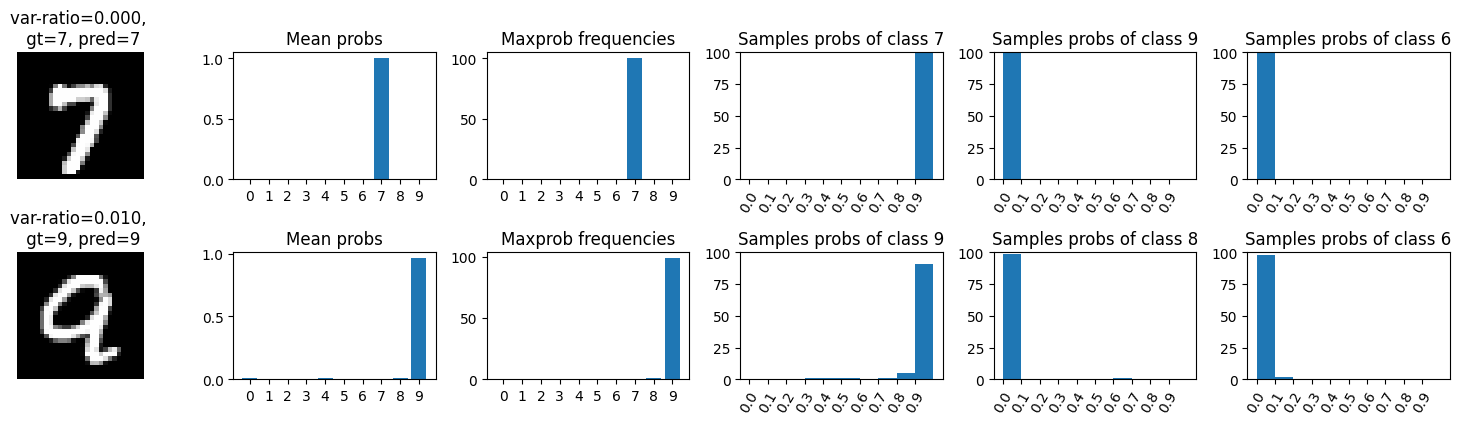

In [11]:
# Plotting random images with their var-ratios value
random_samples = np.random.choice(uncertainty_var.shape[0], 2, replace=False)
plot_predicted_images(
    random_samples,
    test_loader.dataset.data,
    pred_var,
    labels,
    uncertainty_var,
    hists,
    mc_samples,
)

We compare this random sample to the most uncertain images according to the var-ratio.

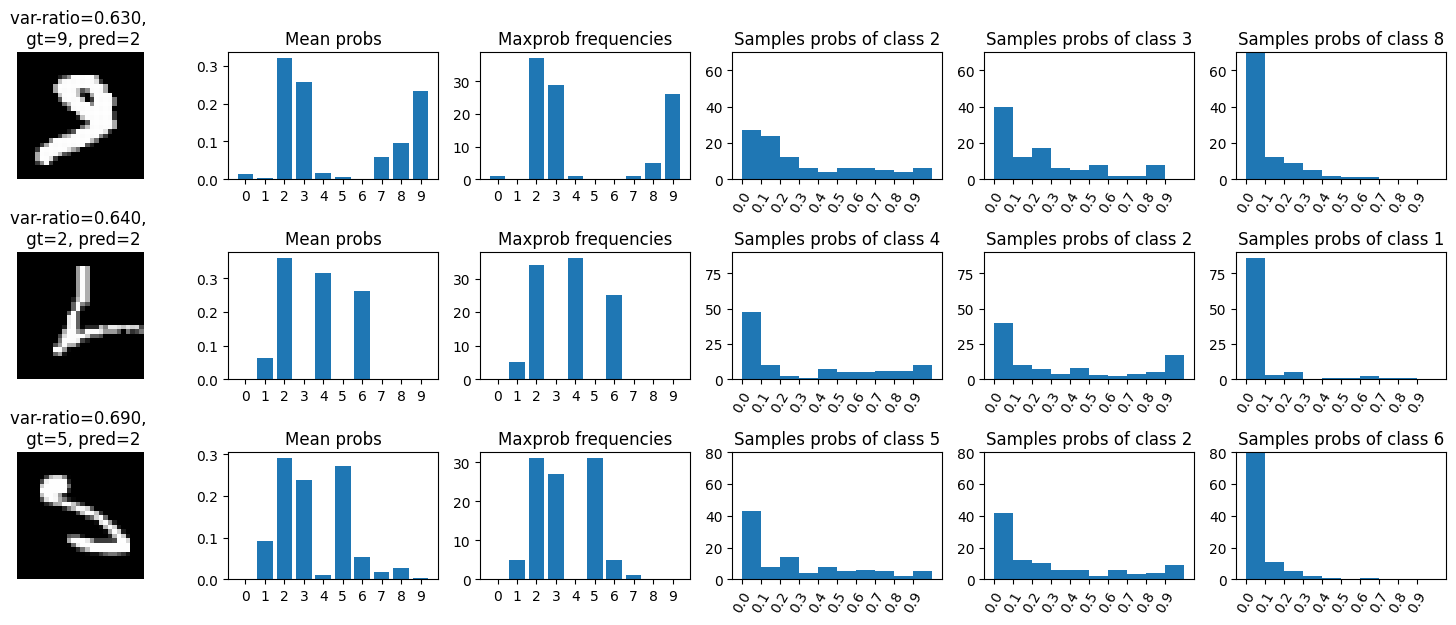

In [12]:
# @title **[CODING TASK]** Visualize the top-3 most uncertain images along with their var-ratios value

# ============ YOUR CODE HERE ============
# Re-use the function 'plot_predicted_images' to visualize
# results.
sorted = np.argsort(uncertainty_var)
plot_predicted_images(
    sorted[-3:],
    test_loader.dataset.data,
    pred_var,
    labels,
    uncertainty_var,
    hists,
    mc_samples,
)

**[Question 1.1]: What can you say about the images themselfs. How do the histograms along them helps to explain failure cases? Finally, how do probabilities distribution of random images compare to the previous top uncertain images?**

## Part II: Failure prediction

The objective is to provide confidence measures for model’s predictions that are reliable and whoseranking among samples enables to distinguish correct from incorrect predictions. Equipped with sucha confidence measure, a system could decide to stick to the prediction or, on the contrary, to handover to a human or a back-up system with,e.g.other sensors, or simply to trigger an alarm.

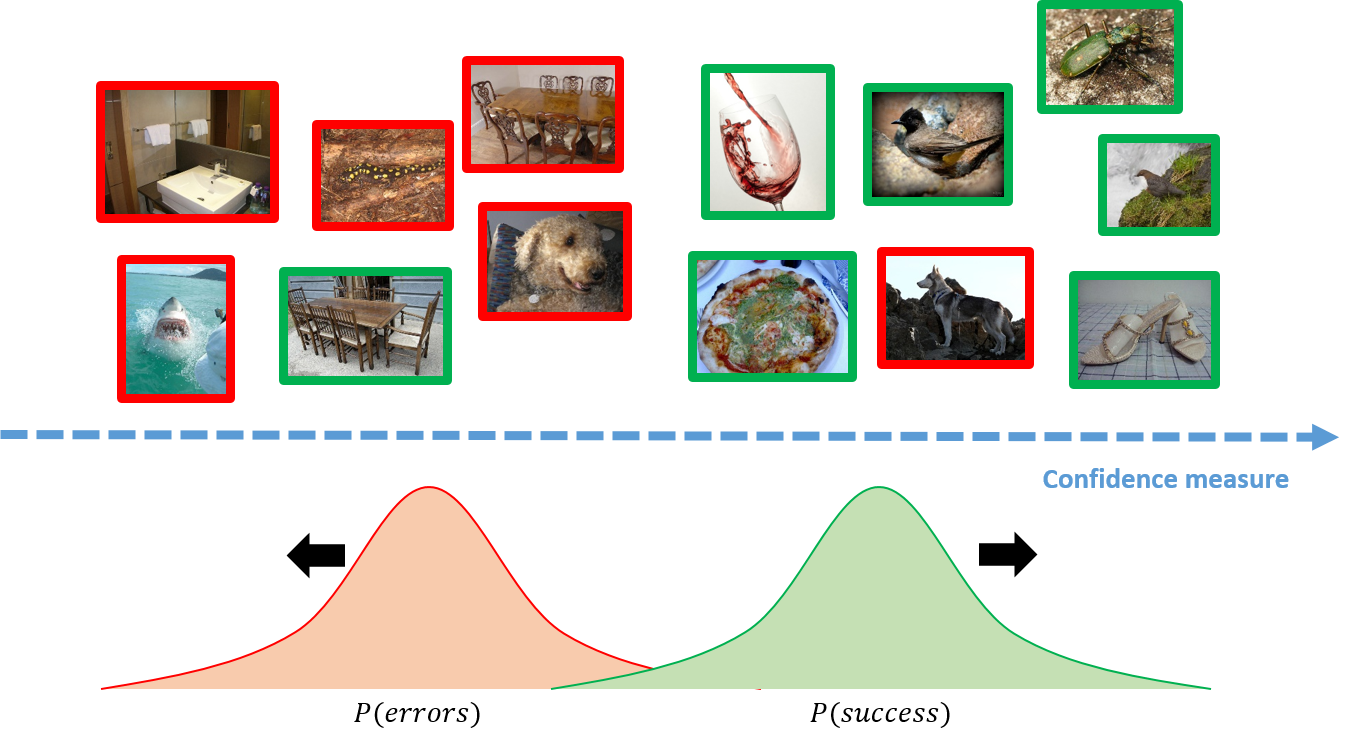

We will introduce ConfidNet, a specific method design to address failure prediction and we will compare it to MCDropout with entropy and Maximum Class Probability (MCP).

### II.1 ConfidNet

By taking the largest softmax probability as confidence estimate, MCP leads to high confidence values both for correct and erroneous predictions alike. On the other hand, when the model misclassifies an example, the probability associated to the true class $y$ is lower than the maximum one and likely to be low.

Based on this observation, we can consider instead the **True Class Probability** as a suitable uncertainty criterion.
For any admissible input $\pmb{x}\in \mathcal{X}$, we assume the *true* class $y(\pmb{x})$ is known, which we denote $y$ for simplicity. The TCP of a model $F$ is defined as  
\begin{equation}
    \text{TCP}_F(\pmb{x},y) = P(Y=y \vert \pmb{x}, \hat{\pmb{w}})
\end{equation}

**Theoretical guarantees.** Given a properly labelled example $(\pmb{x},y)$, then:
- $\text{TCP}_F(\pmb{x},y)> 1/2$ $\Rightarrow$ $f(\pmb{x}) = y$, *i.e.* the example is correctly classified by the model;%the example has been correctly classified,
- $\text{TCP}_F(\pmb{x},y) < 1/K$ $\Rightarrow$ $f(\pmb{x}) \neq y$, *i.e.* the example is wrongly classified by the model.

However, the true classes $y$ are obviously not available when estimating confidence on test inputs. Alternatively, we can **learn TCP criterion from data** with an auxiliary model called **ConfidNet**.

ConfidNet is designed as a small multilayer perceptron composed of a succession of dense layers with a final sigmoid activation that outputs $C(\pmb{x};\pmb{\theta})\in[0,1]$. We use a mean-square-error (MSE) loss to train this model:
\begin{equation}
\mathcal{L}_{\text{conf}}(\pmb{\theta};\mathcal{D}) = \frac{1}{N} \sum_{n=1}^N \big(C(\pmb{x}_n;\pmb{\theta}) - \text{TCP}_F(\pmb{x}_n,y_n)\big)^2.
\end{equation}

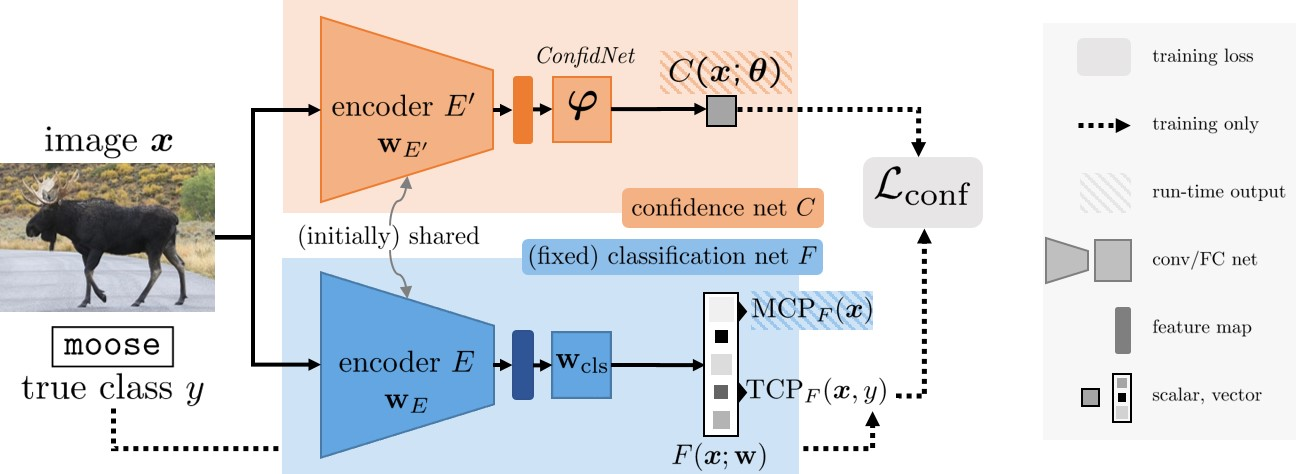

In [13]:
class LeNet5ConfidNet(nn.Module):
    """A LeNet5-syle model equipped with ConfidNet auxiliary branch"""

    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, n_classes)

        # ConfidNet Layers
        self.uncertainty1 = nn.Linear(120, 400)
        self.uncertainty2 = nn.Linear(400, 400)
        self.uncertainty3 = nn.Linear(400, 400)
        self.uncertainty4 = nn.Linear(400, 400)
        self.uncertainty5 = nn.Linear(400, 1)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.maxpool1(out)
        out = F.relu(self.conv2(out))
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.dropout1(out)
        out = F.relu(self.fc1(out))
        out = self.dropout2(out)

        # Uncertainty prediction
        uncertainty = F.relu(self.uncertainty1(out))
        uncertainty = F.relu(self.uncertainty2(uncertainty))
        uncertainty = F.relu(self.uncertainty3(uncertainty))
        uncertainty = F.relu(self.uncertainty4(uncertainty))
        uncertainty = self.uncertainty5(uncertainty)

        pred = self.fc2(out)
        return pred, uncertainty

In [14]:
class SelfConfidMSELoss(nn.modules.loss._Loss):
    """MSE Loss for confidence learning"""

    def __init__(self, num_classes, device):
        self.nb_classes = num_classes
        self.device = device
        super().__init__()

    def forward(self, input, target):
        probs = F.softmax(input[0], dim=1)
        confidence = torch.sigmoid(input[1]).squeeze()
        labels_hot = torch.eye(10, device=device)[target.flatten()]
        loss = (confidence - (probs * labels_hot).sum(dim=1)) ** 2
        return torch.mean(loss)

We train only the ConfidNet layers for 30 epochs. During confidence learning, original classification layers are fixed to keep predictions unchanged.

In [15]:
# lenet_confidnet = LeNet5ConfidNet(n_classes=10).to(device)
# lenet_confidnet.load_state_dict(torch.load("lenet_final.cpkt"), strict=False)
# lenet_confidnet.train()
# optimizer = torch.optim.Adam(lenet_confidnet.parameters(), lr=2e-4)
# criterion = SelfConfidMSELoss(10, device)

# # Freezing every layer except uncertainty for confidence training
# for param in lenet_confidnet.named_parameters():
#     if "uncertainty" in param[0]:
#         continue
#     param[1].requires_grad = False

# for i in range(30):
#     lenet_confidnet.train()
#     # Fine-tuning without stochasticity
#     if i > 20:
#         # Keeping original batch norm values
#         for layer in lenet_confidnet.named_modules():
#             if isinstance(layer[1], torch.nn.BatchNorm2d):
#                 layer[1].momentum = 0
#                 layer[1].eval()
#         # Disabling dropout
#         for layer in lenet_confidnet.named_modules():
#             if "dropout" in layer[0]:
#                 layer[1].eval()

#     total_loss, correct, best_aupr = 0.0, 0.0, 0.0
#     errors, uncertainty = [], []
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         output = lenet_confidnet(images)
#         probs = F.softmax(output[0], dim=1)
#         pred = probs.max(dim=1)[1]
#         loss = criterion(output, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss
#         correct += (pred == labels).sum()
#         errors.extend((pred != labels.view_as(pred)).detach().to("cpu").numpy())
#         uncertainty.extend(output[1].squeeze().detach().to("cpu").numpy())

#     errors = np.reshape(errors, newshape=(len(errors), -1)).flatten()
#     uncertainty = np.reshape(uncertainty, newshape=(len(uncertainty), -1)).flatten()
#     aupr = average_precision_score(errors, -uncertainty)
#     print(
#         f"[Epoch {i + 1}] loss: {total_loss/ len(train_dataset):.2E}"
#         + f"\t accuracy_train: {correct / len(train_dataset):.2%}"
#         + f"\t aupr_train: {aupr:.2%}"
#     )
#     if aupr > best_aupr:
#         best_aupr = aupr
#         torch.save(lenet_confidnet.state_dict(), "lenet_confidnet_best.cpkt")
# lenet_confidnet.load_state_dict(torch.load("lenet_confidnet_best.cpkt"))

In [16]:
# If you already train your model, you can load it instead using :
lenet_confidnet = LeNet5ConfidNet(n_classes=10).to(device)
lenet_confidnet.load_state_dict(torch.load("lenet_confidnet_best.cpkt"))

<All keys matched successfully>

### II.2 Evaluate failure prediction performances

We compare the capacity of ConfidNet to detect failures with previous baselines (MCP and MCDropout with entropy).

To measure performances, we use the *Area under the Precision-Recall* curve (AUPR). The precision-recall (PR) curve is the graph of the precision $= \mathrm{TP}/(\mathrm{TP} + \mathrm{FP})$ as a function of the recall $= \mathrm{TP}/(\mathrm{TP} + \mathrm{FN})$ where $\mathrm{TP}$, $\mathrm{TN}$, $\mathrm{FP}$ and $\mathrm{FN}$ are the numbers of true positives, true negatives, false positives and false negatives respectively. In our experiments, classification errors are used as the positive detection class.

In [17]:
# @title **[CODING TASK]** Compute precision and recall vectors along with AUPR score for ConfidNet

# ============ YOUR CODE HERE ============
# Use predict_test_set function to obtain confidence estimates
# with previous model, choosing 'confidnet' mode.
# Then then calculate the precision, recall and aupr
# with sklearn functions.
# /!\ In failure prediction, errors are consider
# as the positive class

pred_var, labels, uncertainty_var, errors_var, hists, mc_samples = predict_test_set(
    lenet_confidnet, test_loader, mode="confidnet"
)
aupr_confidnet = average_precision_score(errors_var, uncertainty_var)
precision_confidnet, recall_confidnet, _ = precision_recall_curve(
    errors_var, uncertainty_var
)

  0%|          | 0/79 [00:00<?, ?it/s]

Test set accuracy = 99.12%


In [36]:
# @title **[CODING TASK]** Same with MCP

# ============ YOUR CODE HERE ============
Mode = "mcp"
pred_var, labels, uncertainty_var, errors_var, hists, mc_samples = predict_test_set(
    lenet, test_loader, mode=Mode
)
aupr_mcp = average_precision_score(errors_var, uncertainty_var)
precision_mcp, recall_mcp, _ = precision_recall_curve(errors_var, uncertainty_var)

  0%|          | 0/79 [00:00<?, ?it/s]

Test set accuracy = 98.34%


In [37]:
# @title **[CODING TASK]** Same with MCDropout

# ============ YOUR CODE HERE ============
Mode = "entropy"

pred_var, labels, uncertainty_var, errors_var, hists, mc_samples = predict_test_set(
    lenet, test_loader, mode=Mode
)
aupr_ent = average_precision_score(errors_var, uncertainty_var)
precision_ent, recall_ent, _ = precision_recall_curve(errors_var, uncertainty_var)

  0%|          | 0/79 [00:00<?, ?it/s]

Test set accuracy = 99.11%


Let's look at the comparative results for failure prediction

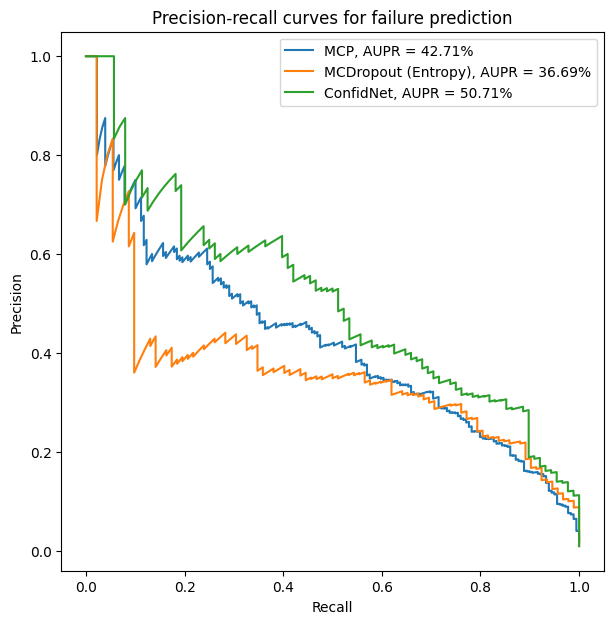

In [20]:
plt.figure(figsize=(7, 7))
plt.plot(recall_mcp, precision_mcp, label=f"MCP, AUPR = {aupr_mcp:.2%}")
plt.plot(recall_ent, precision_ent, label=f"MCDropout (Entropy), AUPR = {aupr_ent:.2%}")
plt.plot(
    recall_confidnet,
    precision_confidnet,
    label=f"ConfidNet, AUPR = {aupr_confidnet:.2%}",
)
plt.title("Precision-recall curves for failure prediction")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

**[Question 2.1]: Compare the precision-recall curves of each method along with their AUPR values. Why did we use AUPR metric instead of standard AUROC?**

## Part III: Out-of-distribution detection

Modern neural networks are known to generalize well when the training and testing data are sampled from the same distribution. However, when deploying neural networks in real-world applications, there is often very little control over the testing data distribution. It is important for classifiers to be aware of uncertainty when shown new kinds of inputs, i.e., out-of- distribution examples. Therefore, being able to accurately detect out-of-distribution examples can be practically important for visual recognition tasks.

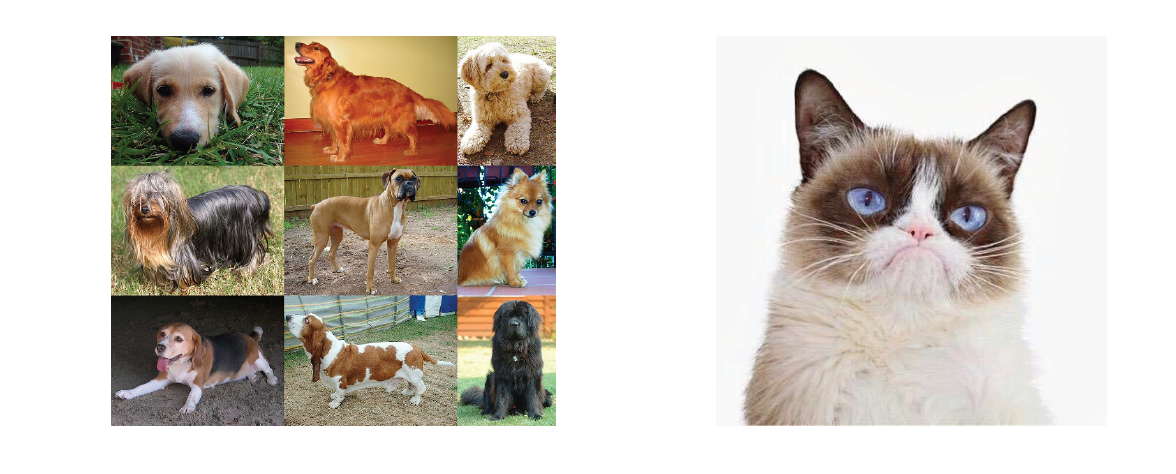

In this section, we will use Kuzushiji-MNIST, a drop-in replacement for the MNIST dataset (28x28 grayscale, 70,000 images) containing 3832 Kanji (japanese) characters, as out-of-distribution sample to our model trained on MNIST. We will compare the methods for uncertainty estimates used previously and ODIN.

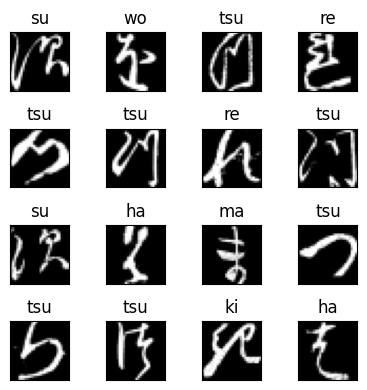

In [21]:
# Load KMNIST dataset
kmnist_test_dataset = datasets.KMNIST(
    "data", train=False, download=True, transform=transform
)
kmnist_test_loader = DataLoader(kmnist_test_dataset, batch_size=128)

# Visualize some images
images, labels = next(iter(kmnist_test_loader))
fig, axes = plt.subplots(nrows=4, ncols=4)
for i, (image, label) in enumerate(zip(images, labels)):
    if i >= 16:
        break
    axes[i // 4][i % 4].imshow(images[i][0], cmap="gray")
    axes[i // 4][i % 4].set_title(f"{kmnist_test_dataset.classes[label]}")
    axes[i // 4][i % 4].set_xticks([])
    axes[i // 4][i % 4].set_yticks([])
fig.set_size_inches(4, 4)
fig.tight_layout()

We compute the precision, recall and AUPR metric for OOD detection with MCP and MCDrpoout with mutual information

In [29]:
# Compute predictions for MCP method on MNIST
_, _, uncertainty_mcp, errors_mcp, _, _ = predict_test_set(
    lenet, test_loader, mode="mcp"
)

# Same on KMNIST
_, _, uncertainty_kmnist, errors_kmnist, _, _ = predict_test_set(
    lenet, kmnist_test_loader, mode="mcp"
)

# Concatenating predictions with MNIST, considering KMNIST samples as out-of-distributions
tot_uncertainty = np.concatenate((uncertainty_mcp, uncertainty_kmnist))
in_distribution = np.concatenate(
    (np.zeros_like(uncertainty_mcp), np.ones_like(uncertainty_kmnist))
)

# Obtaining precision and recall plot vector + AUPR
precision_ood_mcp, recall_ood_mcp, _ = precision_recall_curve(
    in_distribution, tot_uncertainty
)
aupr_ood_mcp = average_precision_score(in_distribution, tot_uncertainty)

  0%|          | 0/79 [00:00<?, ?it/s]

Test set accuracy = 98.34%


  0%|          | 0/79 [00:00<?, ?it/s]

Test set accuracy = 8.81%


In [54]:
# Computing for MCDropout with entropy
_, _, uncertainty_mutinf, _, _, _ = predict_test_set(lenet, test_loader, mode="mut_inf")
_, _, uncertainty_mutinf_kmnist, _, _, _ = predict_test_set(
    lenet, kmnist_test_loader, mode="mut_inf"
)
tot_uncertainty = np.concatenate((uncertainty_mutinf, uncertainty_mutinf_kmnist))
in_distribution = np.concatenate(
    (np.zeros_like(uncertainty_mutinf), np.ones_like(uncertainty_mutinf_kmnist))
)

precision_ood_ent, recall_ood_ent, _ = precision_recall_curve(
    in_distribution, tot_uncertainty
)
aupr_ood_ent = average_precision_score(in_distribution, tot_uncertainty)

  0%|          | 0/79 [00:00<?, ?it/s]

Test set accuracy = 99.06%


  0%|          | 0/79 [00:00<?, ?it/s]

Test set accuracy = 8.55%


We will now implement the ODIN method.

ODIN [[Liang et al., ICLR 2018](https://openreview.net/pdf?id=H1VGkIxRZ)], is a threshold-based detector enhancing maximum softmax probabilities with two extensions:
- **temperature scaling**:
	$ \textit{p}(y= c \vert \mathbf{x}, \mathbf{w}, T) = \frac{\exp(f_c( \mathbf{x}, \mathbf{w}) / T)}{\sum_{k=1}^K \exp(f_k( \mathbf{x}, \mathbf{w}) / T)} $
where $T \in \mathbb{R}^{+}$
- **inverse adversarial perturbation**: $ \tilde{\mathbf{x}} = \mathbf{x} - \epsilon \mathrm{sign} \big ( - \nabla_x \log (\textit{p}(y = \hat{y} \vert \mathbf{x}, \mathbf{w}, T) \big ) $

Both technics aimed to increase in-distribution MCP higher than out-distribution MCP. Here, we set the hyperparameters $T=5$ and $\epsilon=0.0014$.

In [58]:
# @title **[CODING TASK]** Implement ODIN preprocessing


def odin_preprocessing(model, input, epsilon):
    # We perform the invese adversarial perturbation
    # You can find some help in the link below:
    # https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

    # ============ YOUR CODE HERE ============
    # 1. Set requires_grad attribute of tensor. Important for Attack
    input.requires_grad = True
    # 2. Forward pass the data through the model
    output = model(input)
    # 3. Calculate the loss w.r.t to class predictions
    loss = F.cross_entropy(output, output.argmax(-1))
    # 4. Zero all existing gradients
    model.zero_grad()
    # 5. Calculate gradients of model in backward pass
    loss.backward()
    # 6. Collect sign of datagrad
    sign_input_grad = (-input.grad.data).sign()
    # 7. Normalizing the gradient to the same space of image
    sign_input_grad = sign_input_grad / 0.3081

    # 8. Apply FGSM Attack
    perturbed_input = input - epsilon * sign_input_grad
    return perturbed_input

In [68]:
# Compute predictions for ODIN on MNIST
_, _, uncertainty_odin, errors_odin, _, _ = predict_test_set(
    lenet, test_loader, mode="odin", temp=5, epsilon=0.006
)

# Compute predictions for ODIN on KMNIST
_, _, uncertainty_kmnist, errors_kmnist, _, _ = predict_test_set(
    lenet, kmnist_test_loader, mode="odin", temp=5, epsilon=0.0006
)

# Concatenating predictions with MNIST, considering KMNIST samples as out-of-distributions
tot_uncertainty = np.concatenate((uncertainty_odin, uncertainty_kmnist))
in_distribution = np.concatenate(
    (np.zeros_like(uncertainty_odin), np.ones_like(uncertainty_kmnist))
)

# Obtaining precision and recall plot vector + AUPR
precision_ood_odin, recall_ood_odin, _ = precision_recall_curve(
    in_distribution, tot_uncertainty
)
aupr_ood_odin = average_precision_score(in_distribution, tot_uncertainty)

  0%|          | 0/79 [00:00<?, ?it/s]

Test set accuracy = 98.13%


  0%|          | 0/79 [00:00<?, ?it/s]

Test set accuracy = 8.82%


Let's look at the comparative results for failure prediction

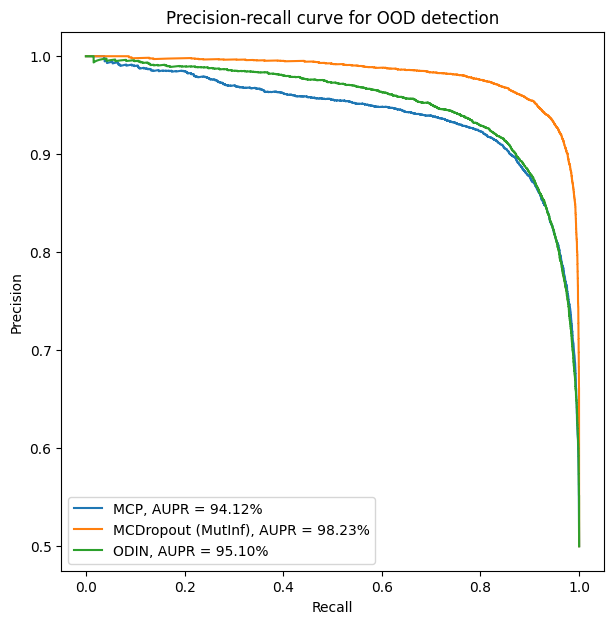

In [69]:
plt.figure(figsize=(7, 7))
plt.title("Precision-recall curve for OOD detection")
plt.plot(recall_ood_mcp, precision_ood_mcp, label=f"MCP, AUPR = {aupr_ood_mcp:.2%}")
plt.plot(
    recall_ood_ent,
    precision_ood_ent,
    label=f"MCDropout (MutInf), AUPR = {aupr_ood_ent:.2%}",
)
plt.plot(recall_ood_odin, precision_ood_odin, label=f"ODIN, AUPR = {aupr_ood_odin:.2%}")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

**[Question 3.1]: Compare the precision-recall curves of each OOD method along with their AUPR values. Which method perform best and why?**